- **Deposit과 Default 간의 연관성 가설**:

    - 더 많은 금액의 예금을 가진 고객은 채무를 이행하는 경향이 더 높을 것이다.
        
        ↔ 예금이 적은 고객은 금전적 여유가 적을 가능성이 있고, 이로 인해 대출 채무를 이행하는 데 어려움을 겪을 수 있다.
        
    - 예금의 기간이 길수록 채무 이행하는 경향이 높을 것이다.

In [1]:
import os, glob
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PATH_DATASET = Path("../data")
PATH_PARQUETS = PATH_DATASET / "parquet_files"
PARQUETS_TRAIN = PATH_PARQUETS / "train"
PARQUETS_TEST = PATH_PARQUETS / "test"

In [2]:
base = pl.read_parquet(PARQUETS_TRAIN / 'train_base.parquet')
df = pl.read_parquet(PARQUETS_TRAIN / 'train_deposit_1.parquet')

In [3]:
df = df.select(pl.exclude('num_group1'))
df = df.with_columns(pl.col('contractenddate_991D', 'openingdate_313D').str.to_datetime().dt.date())

In [4]:
df.null_count()

case_id,amount_416A,contractenddate_991D,openingdate_313D
u32,u32,u32,u32
0,0,79682,0


In [5]:
base.describe()

statistic,case_id,date_decision,MONTH,WEEK_NUM,target
str,f64,str,f64,f64,f64
"""count""",1.526659e6,"""1526659""",1.526659e6,1.526659e6,1.526659e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",1.2861e6,null,201936.287982,40.769036,0.031437
"""std""",718946.592285,null,44.735975,23.797981,0.174496
"""min""",0.0,"""2019-01-01""",201901.0,0.0,0.0
"""25%""",766198.0,null,201906.0,23.0,0.0
"""50%""",1.357358e6,null,201910.0,40.0,0.0
"""75%""",1.739023e6,null,202001.0,55.0,0.0
"""max""",2.703454e6,"""2020-10-05""",202010.0,91.0,1.0


- `amount_416A`: Deposit amount.
- `contractenddate_991D`: 계약 종료일
- `openingdate_313D`: deposit 시작일

-> contractenddate_991D 데이터가 null 인경우 예금 / 있는 경우 저축으로 분류 가능?

In [6]:
# saving - 저축 유무
df = df.with_columns(pl.col('contractenddate_991D').is_not_null().alias('saving'))
df.head()

case_id,amount_416A,contractenddate_991D,openingdate_313D,saving
i64,f64,date,date,bool
225,0.0,null,2016-08-16,false
331,260.374,2018-03-18,2015-03-19,true
358,0.0,null,2014-09-02,false
390,211748.53,2017-07-22,2014-07-23,true
390,223.68001,null,2016-06-08,false


In [7]:
df.describe()

statistic,case_id,amount_416A,contractenddate_991D,openingdate_313D,saving
str,f64,f64,str,str,f64
"""count""",145086.0,145086.0,"""65404""","""145086""",145086.0
"""null_count""",0.0,0.0,"""79682""","""0""",0.0
"""mean""",1.4662e6,8422.304482,"""2018-01-18""","""2015-06-13""",0.450795
"""std""",886528.958911,86232.120476,null,null,null
"""min""",225.0,-40000.0,"""2002-02-27""","""2001-11-19""",0.0
"""25%""",660041.0,0.0,"""2017-09-30""","""2014-07-03""",null
"""50%""",1.556939e6,223.658,"""2018-01-21""","""2015-06-22""",null
"""75%""",2.530539e6,478.34,"""2018-06-25""","""2016-04-27""",null
"""max""",2.703453e6,1.2213286e7,"""2020-03-18""","""2017-07-31""",1.0


- 예금이 `-` 인 경우가 존재한다. default 와의 연관성은?
- 저축을 하는사람과 예금을 하는 사람의 양을 비교하고싶네

In [10]:
df['case_id'].value_counts().filter(pl.col('count')>2).describe()

statistic,case_id,count
str,f64,f64
"""count""",7878.0,7878.0
"""null_count""",0.0,0.0
"""mean""",1.4430e6,3.768215
"""std""",912436.756489,2.050299
"""min""",390.0,3.0
"""25%""",250130.0,3.0
"""50%""",1.532192e6,3.0
"""75%""",2.535663e6,4.0
"""max""",2.70343e6,65.0


- 중복되는 예/적금이 많다.
- 예/적금이 많으면 default 가 적게 나타난다? (다만 표본이 좀 적다)
- 예/적금은 많은데 전부다 비어있거나 거래가 안되는통장이라면?

`EDA Example`
- 여러 개의 deposit 이 존재할 떄, default 는?

In [22]:
heavy_deposit = df['case_id'].value_counts().filter((pl.col('count')>=3) & (pl.col('count')<=18)).sort(by='case_id')
heavy_deposit_case_ids = heavy_deposit['case_id'].to_list()
filtered_df = base.filter(pl.col('case_id').is_in(heavy_deposit_case_ids))
target_count = filtered_df.filter(pl.col('target') == 1)
len(target_count) / len(filtered_df)

0.014014524143202955

In [12]:
ans = []
for num in range(3, 33):
    heavy_deposit = df['case_id'].value_counts().filter(pl.col('count')>=num).sort(by='case_id')
    heavy_deposit_case_ids = heavy_deposit['case_id'].to_list()
    filtered_df = base.filter(pl.col('case_id').is_in(heavy_deposit_case_ids))
    target_count = filtered_df.filter(pl.col('target') == 1)
    ratio = len(target_count) / len(filtered_df)
    ans.append((num, ratio))

Text(0.5, 1.0, 'Default ratio according to the number of deposits')

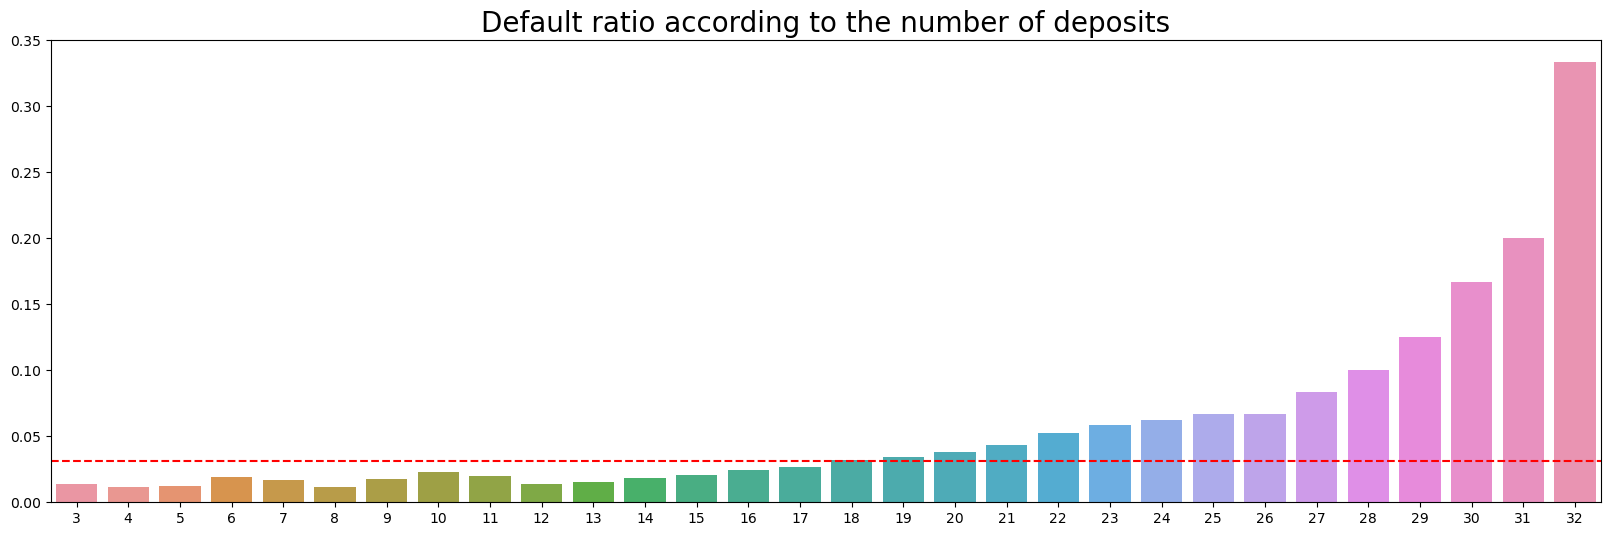

In [14]:
# 배열을 x와 y 리스트로 분리
x_values = [item[0] for item in ans]
y_values = [item[1] for item in ans]
plt.figure(figsize=(20, 6))
sns.barplot(x=x_values, y=y_values)
plt.axhline(y=0.03143727577671242, color='r', linestyle='--', label='total_mean')
plt.title('Default ratio according to the number of deposits', fontsize=20)

`EDA2`
 1. deposit 이 존재하는 고객은 deafult 가 적은가
 

In [17]:
unique_case_ids = df.select('case_id').unique().sort(by='case_id')['case_id'].to_list()

In [19]:
deposit_base = base.with_columns(pl.col('case_id').is_in(unique_case_ids).alias('is_deposit'))

In [25]:
deposit_base['is_deposit'].value_counts()

is_deposit,count
bool,u32
true,105111
false,1421548


<Axes: xlabel='is_deposit', ylabel='target'>

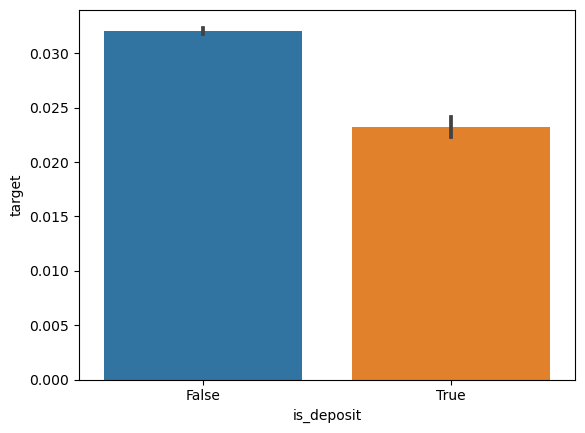

In [24]:
data = deposit_base.select(pl.col('is_deposit', 'target')).to_pandas()
sns.barplot(x=data['is_deposit'], y=data['target'])

In [29]:
from scipy.stats import fisher_exact
import pandas as pd

# 2x2 contingency table 생성
contingency_table = pd.crosstab(data['is_deposit'], data['target'])
# Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)
# 결과 출력
print(f"Odds Ratio: {odds_ratio}, p-value: {p_value}")

Odds Ratio: 0.7165775533454156, p-value: 6.705531087305051e-62


`EDA3`
- Deposit 금액에 따른 default

In [9]:
df.describe()

statistic,case_id,amount_416A,contractenddate_991D,openingdate_313D,saving
str,f64,f64,str,str,f64
"""count""",145086.0,145086.0,"""65404""","""145086""",145086.0
"""null_count""",0.0,0.0,"""79682""","""0""",0.0
"""mean""",1.4662e6,8422.304482,"""2018-01-18""","""2015-06-13""",0.450795
"""std""",886528.958911,86232.120476,null,null,null
"""min""",225.0,-40000.0,"""2002-02-27""","""2001-11-19""",0.0
"""25%""",660041.0,0.0,"""2017-09-30""","""2014-07-03""",null
"""50%""",1.556939e6,223.658,"""2018-01-21""","""2015-06-22""",null
"""75%""",2.530539e6,478.34,"""2018-06-25""","""2016-04-27""",null
"""max""",2.703453e6,1.2213286e7,"""2020-03-18""","""2017-07-31""",1.0


In [50]:

median = df.filter(pl.col('amount_416A') > df['amount_416A'].median())

In [47]:
unique_median_ids = median.select('case_id').unique().sort(by='case_id')['case_id'].to_list()
deposit_base = base.with_columns(pl.col('case_id').is_in(unique_median_ids).alias('is_median_deposit'))
deposit_base['is_median_deposit'].value_counts()

is_median_deposit,count
bool,u32
false,1459462
true,67197


<Axes: xlabel='is_median_deposit', ylabel='target'>

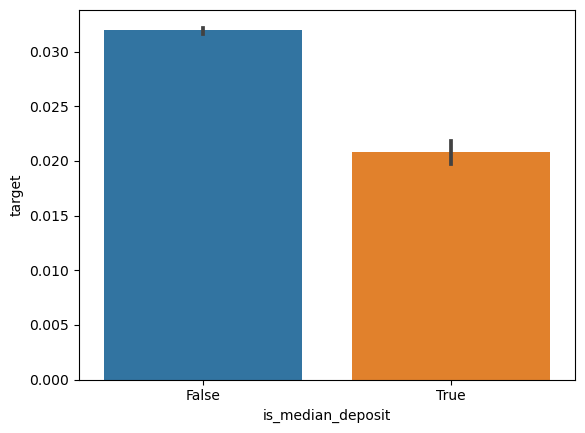

In [48]:
data = deposit_base.select(pl.col('is_median_deposit', 'target')).to_pandas()
sns.barplot(x=data['is_median_deposit'], y=data['target'])

In [49]:
from scipy.stats import fisher_exact
import pandas as pd

# 2x2 contingency table 생성
contingency_table = pd.crosstab(data['is_median_deposit'], data['target'])
# Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)
# 결과 출력
print(f"Odds Ratio: {odds_ratio}, p-value: {p_value}")

Odds Ratio: 0.644228918279468, p-value: 8.374385857749228e-66


`EDA4`
- 금액이 0 이하인 deposit 이 있는 경우 어떻게 처리할까.

In [51]:
df

case_id,amount_416A,contractenddate_991D,openingdate_313D,saving
i64,f64,date,date,bool
225,0.0,null,2016-08-16,false
331,260.374,2018-03-18,2015-03-19,true
358,0.0,null,2014-09-02,false
390,211748.53,2017-07-22,2014-07-23,true
390,223.68001,null,2016-06-08,false
390,203.602,2017-09-30,2015-10-01,true
445,23735.938,null,2016-07-19,false
445,0.0,2017-07-31,2015-08-01,true
445,0.0,null,2016-02-22,false


In [70]:
saving_df = df.filter((pl.col('saving')) & (pl.col('amount_416A') > 0))
non_zero_saving_ids = saving_df.select('case_id').unique().sort(by='case_id')['case_id'].to_list()
deposit_base = base.with_columns(pl.col('case_id').is_in(non_zero_saving_ids).alias('is_non_zero_deposit'))
deposit_base['is_non_zero_deposit'].value_counts()

is_non_zero_deposit,count
bool,u32
false,1477338
true,49321


Odds Ratio: 0.6095988354443331, p-value: 1.5677717741223311e-38


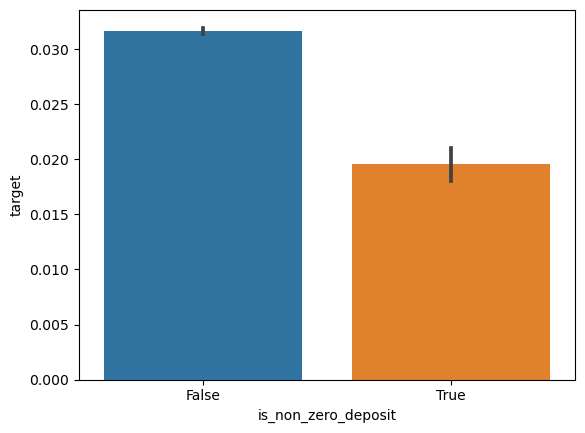

In [69]:
data = deposit_base.select(pl.col('is_non_zero_deposit', 'target')).to_pandas()
sns.barplot(x=data['is_non_zero_deposit'], y=data['target'])

# 2x2 contingency table 생성
contingency_table = pd.crosstab(data['is_non_zero_deposit'], data['target'])
# Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)
# 결과 출력
print(f"Odds Ratio: {odds_ratio}, p-value: {p_value}")